# Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# A look at the data

In [75]:
df = pd.read_csv("winemag-data_first150k.csv") 
df = df.rename(columns={"Unnamed: 0": "id"})
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


# Test of the library NLTK

### TOKENIZING

In [76]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re

In [77]:
desc = df['description'][0]
# desc

In [78]:
sentences = list(sent_tokenize(desc))
# sentences

In [79]:
def remove_punctuation(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

In [80]:
cleaned_sentences = [remove_punctuation(sentence) for sentence in sentences]
# cleaned_sentences

In [81]:
partial_desc_words = [word_tokenize(sentence) for sentence in cleaned_sentences]
# partial_desc_words

 ### REMOVING STOP WORDS

In [82]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))
# stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olgob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
def remove_stopwords(sentence):
    return [words for words in sentence if not words in stop_words]

In [84]:
filtered = [remove_stopwords(s) for s in partial_desc_words]
word_count = len([w for words in partial_desc_words for w in words])
word_count_2 = len([w for words in filtered for w in words])
print(word_count, word_count_2)

60 37


### PART OF SPEECH TAGGING

In [85]:
POS = [nltk.pos_tag(tokenized_sent) for tokenized_sent in filtered ]
# POS

### Worldcloud

In [86]:
from wordcloud import WordCloud

In [87]:
full_descriptions = ",".join(df['description'].values)

In [88]:
clean_test = remove_punctuation(full_descriptions)

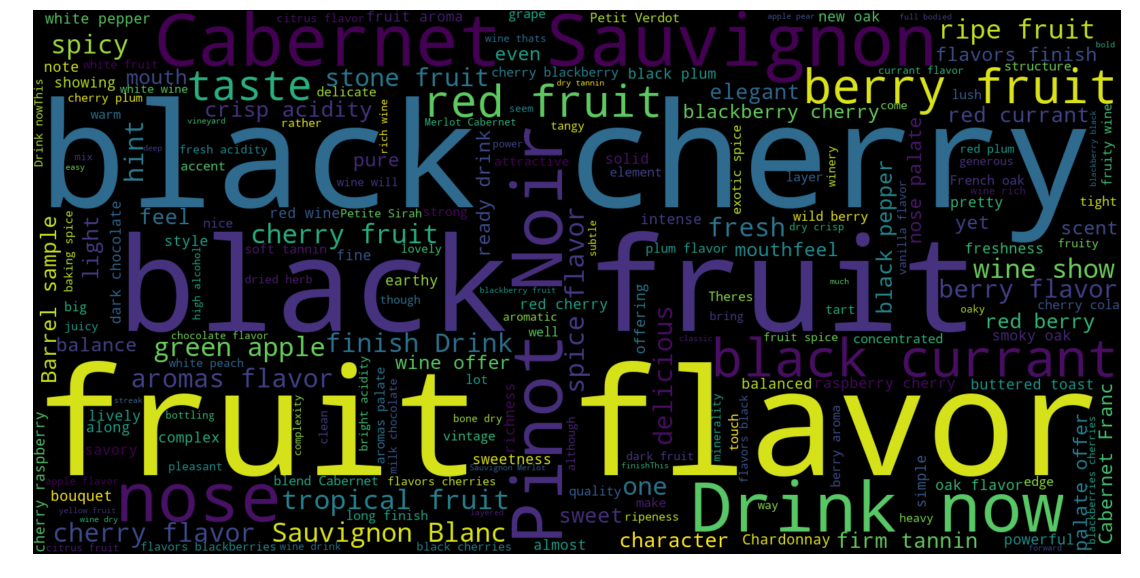

In [197]:
wordcloud = WordCloud(width=1600, height=800).generate(clean_test)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('word_cloud_wine_description.pdf',orientation='portrait',format = 'pdf')

# Sentiment analysis with NLTK

In [105]:
points_dist = df.groupby('points').count()
points_dist.index

Int64Index([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
             93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64', name='points')

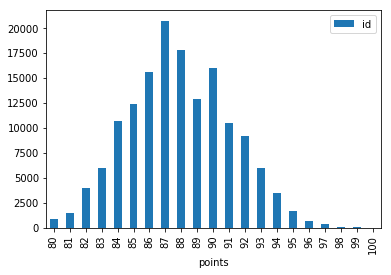

In [185]:
points_dist.plot.bar(y='id', rot=90);

In [103]:
from scipy.optimize import curve_fit

In [104]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [140]:
popt, pcov = curve_fit(gauss_function, points_dist.index, points_dist['id'], p0 = [1, 88, 4])
amp, x0, sigma = popt

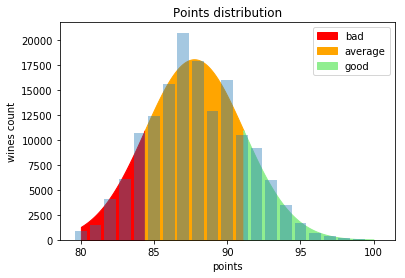

In [180]:
fig, ax = plt.subplots()
ax.bar(points_dist.index, points_dist['id'], alpha=0.4)
x = np.linspace(min(points_dist.index), max(points_dist.index), 1000)
ax.set_title('Points distribution');
ax.set_ylabel('wines count');
ax.set_xlabel('points');
x_bad = np.linspace(min(x), x0-sigma, 300)
ax.fill_between(x_bad, gauss_function(x_bad, amp, x0, sigma), color = 'red', label='bad')
x_average = np.linspace(x0-sigma, x0+sigma, 300)
ax.fill_between(x_average, gauss_function(x_average, amp, x0, sigma), color = 'orange', label='average')
x_good = np.linspace(x0+sigma, max(x), 300)
ax.fill_between(x_good, gauss_function(x_good, amp, x0, sigma), color = 'lightgreen', label='good')
ax.legend();

The average rate for a wine is 87.73.

We can split the wine in average, bad or good, taking the standard deviation and the mean value of this distribution. <br /> So we have :

bad_wines : points <= 84 <br />
average_wines : 84 < points <= 91 <br />
good_wines : 91 < points <br />

In [207]:
df_bad = df[df['points']<=84]
df_avg = df[(df['points']>84) & (df['points']<=91)]
df_good = df[df['points']>91]

In [326]:
def getAdjectives(df):
    full_descriptions = ",".join(df['description'].values).lower()
    sentences = list(sent_tokenize(full_descriptions))
    sentences_no_punct = [remove_punctuation(sentence) for sentence in sentences]
    words = [word_tokenize(sentence) for sentence in sentences_no_punct]
    filtered_desc = [remove_stopwords(s) for s in words]
    
    POS = [nltk.pos_tag(tokenized_sent) for tokenized_sent in filtered_desc]
    adjectives = []
    n = 0
    while n < len(POS):
        for word, pos in POS[n]:
            if pos=='JJ' or pos=='JJR' or pos=='JJS':
                adjectives.append(word)
        n +=1
    return adjectives

In [327]:
bad_adjectives = getAdjectives(df_bad)

In [329]:
avg_adjectives = getAdjectives(df_avg)

In [334]:
good_adjectives = getAdjectives(df_good)

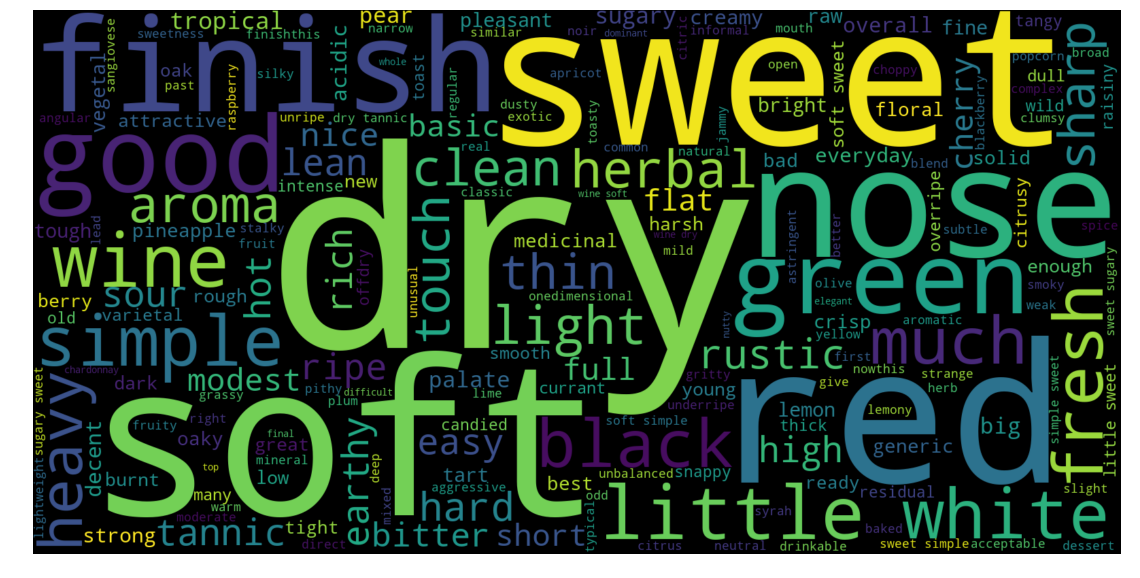

In [332]:
wordcloud = WordCloud(width=1600, height=800).generate(",".join(bad_adjectives))
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('bad_adjectives.pdf',orientation='portrait',format = 'pdf')

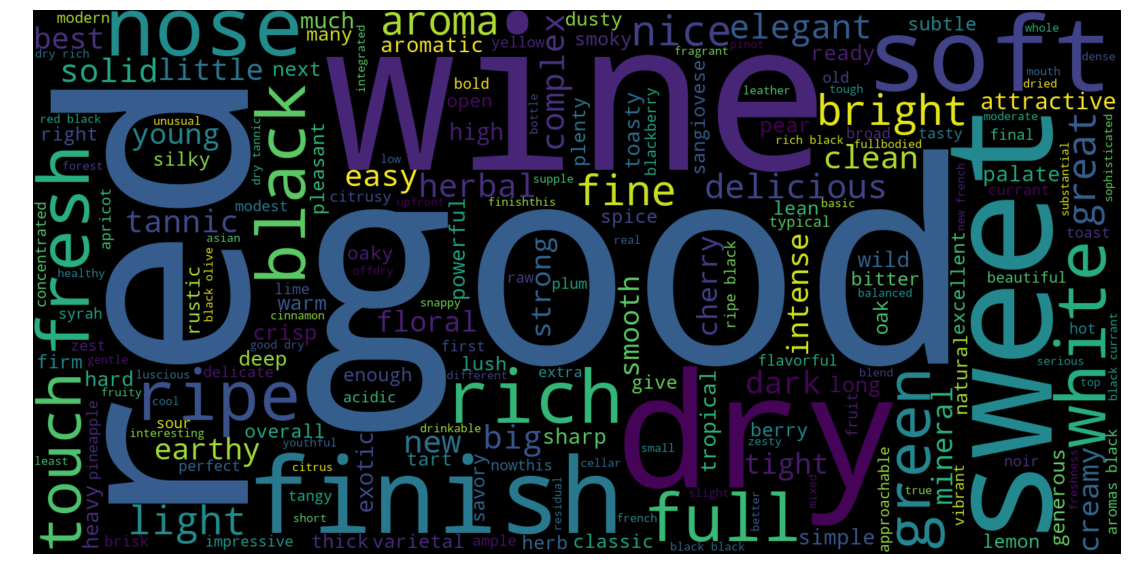

In [333]:
wordcloud = WordCloud(width=1600, height=800).generate(",".join(avg_adjectives))
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('avg_adjectives.pdf',orientation='portrait',format = 'pdf')

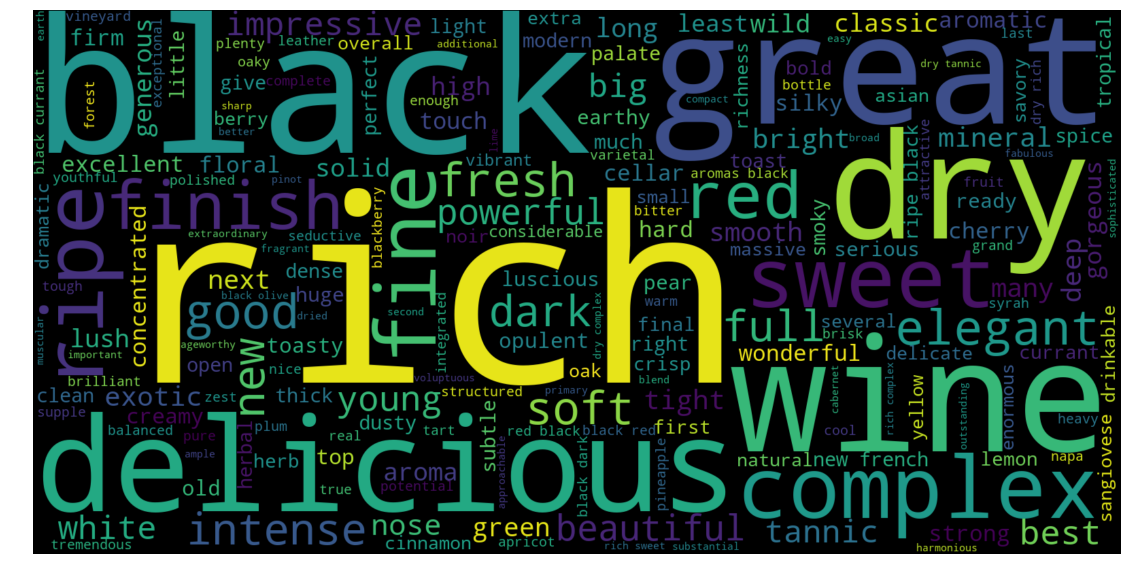

In [335]:
wordcloud = WordCloud(width=1600, height=800).generate(",".join(good_adjectives))
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('good_adjectives.pdf',orientation='portrait',format = 'pdf')

In [348]:
from nltk.probability import FreqDist

def getFreqWordsDic(df):
    full_descriptions = ",".join(df['description'].values).lower()
    sentences = list(sent_tokenize(full_descriptions))
    sentences_no_punct = [remove_punctuation(sentence) for sentence in sentences]
    words = [word_tokenize(sentence) for sentence in sentences_no_punct]
    filtered_desc = [remove_stopwords(s) for s in words]
    flat_filtered_desc = [item for sublist in filtered_desc for item in sublist]
    fdist = FreqDist(word for word in flat_filtered_desc)
    return fdist

In [350]:
bad_adjectives_freq = getFreqWordsDic(df_bad)

In [351]:
avg_adjectives_freq = getFreqWordsDic(df_avg)

In [352]:
good_adjectives_freq = getFreqWordsDic(df_good)

In [355]:
bad_adjectives_freq

FreqDist({'flavors': 13038, 'wine': 9733, 'fruit': 6086, 'aromas': 5273, 'palate': 4737, 'cherry': 4315, 'sweet': 4262, 'finish': 3834, 'acidity': 3210, 'dry': 3181, ...})

In [353]:
avg_adjectives_freq

FreqDist({'wine': 58785, 'flavors': 51601, 'fruit': 39938, 'aromas': 25475, 'cherry': 21590, 'acidity': 21335, 'tannins': 20812, 'palate': 20350, 'finish': 18858, 'ripe': 18799, ...})

In [354]:
good_adjectives_freq

FreqDist({'wine': 16250, 'flavors': 9770, 'fruit': 8836, 'tannins': 6469, 'black': 5609, 'rich': 5369, 'ripe': 5128, 'acidity': 4894, 'cherry': 4487, 'drink': 4280, ...})